# EYE FOR BLIND

In [191]:
#Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import os
import glob

import skimage.io
from skimage.io import imread
from skimage import transform
from skimage import feature
from skimage.transform import rotate, AffineTransform
from skimage.util import random_noise
import tensorflow as tf


import random

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [192]:
from tensorflow import keras
#import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, TimeDistributed, BatchNormalization, Activation, Dropout
#from tensorflow.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [193]:
#from keras.layers import Attention

Let's read the dataset

In [194]:
print(tf.__version__)

2.4.1


## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [195]:
#Import the dataset and read the image into a seperate variable

images='../input/flickr8k/Images'
print(images + '/*.jpg')
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

../input/flickr8k/Images/*.jpg
The total images present in the dataset: 8091


In [196]:
import os
print(os.listdir("../input/flickr8k/"))

['captions.txt', 'Images']


## Visualization of images and text:
  * We now read the file `captions.txt`
  * Pick a few image names from this file
  * Show the images using *plt.imshow()*
  * We also check the RGB images for 1 image

A few captions:
image,caption

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg,A girl going into a wooden building .

1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .

Image Names:
['image', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1001773457_577c3a7d70.jpg', '1001773457_577c3a7d70.jpg', '1001773457_577c3a7d70.jpg']

No. of captions: 40456


Number of images: 8092


No. of captions per image: 5



Sizes of some images: (375, 500, 3), (375, 500, 3), (500, 333, 3), (500, 375, 3)


A few images and RGB plots of 1 image:


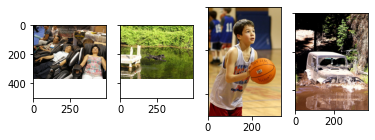

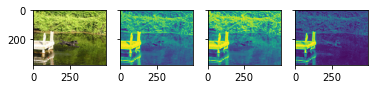

In [197]:
#Visualise both the images & text present in the dataset

k = 0
cap_path = '../input/flickr8k/'
img_path = '../input/flickr8k/Images/'
imgname = []
print("A few captions:")
print(15*'=')
with open(cap_path + 'captions.txt') as fptr:
    for line in fptr:
        if(k < 5):
            print(line)
#        if(k > 39):
#            break
        imgname.append(line.split(',')[0])
        k += 1
    print('Image Names:')
    print(12*'=')
    print(imgname[:10])

print()
print(f"No. of captions: {len(imgname)}")
print()

    
unique_imgs = list(set(imgname))
print()
print(f'Number of images: {len(unique_imgs)}')
print()

print()
print(f"No. of captions per image: {int(round(len(imgname)/len(unique_imgs), 0))}")
print()

imgs= []
for k in range(1, 5):
    imgs.append(imread(img_path + unique_imgs[k]))

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey = True)
ax1.imshow(imgs[0])
ax2.imshow(imgs[1])
ax3.imshow(imgs[2])
ax4.imshow(imgs[3])
print()
print()
print(f'Sizes of some images: {imgs[0].shape}, {imgs[1].shape}, {imgs[2].shape}, {imgs[3].shape}')
print(21*'=')

print()
print()
print("A few images and RGB plots of 1 image:")
print(38*'=')

img = imgs[1]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey = True)
ax1.imshow(img)
ax2.imshow(img[:, :, 0])
ax3.imshow(img[:, :, 1])
ax4.imshow(img[:, :, 2])

plt.show()

In [198]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    text = []
    with open(filename) as fptr:
        for line in fptr:
            text.append(line.split('\n')[0])
    text.pop(0)
    return text

text_file = cap_path + 'captions.txt'
doc = load_doc(text_file)
print(doc[:30])

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', '

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [199]:
all_img_id= [cap.split(',')[0] for cap in doc]                        #store all the image id here
all_img_vector= [img_path + img_name for img_name in all_img_id]      #store all the image path here
annotations= [''.join(cap.split(',')[1:]) for cap in doc]                       #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [200]:
#Create the vocabulary & the counter for the captions

vocabulary = [word for sentence in annotations for word in sentence.split()]       #write your code here

def Counter(voc):
    return(len(voc))

val_count=Counter(vocabulary)
print(vocabulary[:100])
val_count

['A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', 'A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', 'A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', 'A', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', 'A', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', 'A', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', 'A', 'black', 'dog', 'and', 'a', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road', '.', 'A', 'black', 'dog', 'and', 'a', 'white', 'dog', 'with', 'brown', 'spots', 'are', 'staring', 'at', 'each', 'other', 'in', 'the', 'street']


473455

In [201]:
#Visualise the top 30 occuring words in the captions
import collections

#write your code here
counts = collections.Counter(vocabulary)
sorted_counts = sorted(counts.items(), key = lambda item: item[1], reverse = True)
print(dict(sorted_counts[:30]))

{'a': 40271, '.': 34212, 'A': 21481, 'in': 18961, 'the': 15328, 'on': 10729, 'is': 9345, 'and': 8850, 'dog': 7982, 'with': 7760, 'man': 6828, 'of': 6712, 'Two': 3962, 'white': 3875, 'black': 3696, 'are': 3503, 'boy': 3442, 'woman': 3227, 'girl': 3217, 'to': 3173, 'wearing': 3061, 'The': 2920, 'at': 2904, 'water': 2774, 'red': 2660, 'brown': 2475, 'people': 2442, 'young': 2431, '."': 2365, 'his': 2357}


In [202]:
#Create a list which contains all the captions
annotations = annotations                                      #write your code here

#add the <start> & <end> token to all those captions as well
annotations = ['<start> ' + caption + ' <end>' for caption in annotations]
print(annotations[:4])
print()

#Create a list which contains all the path to the images
all_img_path = all_img_vector                                  #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>']

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

## Test tokenizer
* This tokenizer is **not** the final tokenizer
* I have written this tokenizer through normal python code
* The **final tokenizer** is written below with the **keras tokenizer**

In [203]:
# create the tokenizer

#your code here

vocab = [word for sentence in annotations for word in sentence.split()]       #write your code here
print(vocab[:50])

#write your code here
counts = collections.Counter(vocab)
sorted_counts = sorted(counts.items(), key = lambda item: item[1], reverse = True)
print(dict(sorted_counts[:30]))

tokens = list(dict(sorted_counts).keys())
print(tokens[:10])
l_tokens = len(tokens)
for i in range(l_tokens):
    if (i >= 5000):
        tokens[i] = "UNK"

print(tokens[4990:5010])

capts = []
print()
print()
for sentence in annotations:
    capts.append(sentence.split())
print(capts[:10])

['<start>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<end>', '<start>', 'A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<end>', '<start>', 'A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<end>', '<start>', 'A', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her']
{'<start>': 40455, '<end>': 40455, 'a': 40271, '.': 34212, 'A': 21481, 'in': 18961, 'the': 15328, 'on': 10729, 'is': 9345, 'and': 8850, 'dog': 7982, 'with': 7760, 'man': 6828, 'of': 6712, 'Two': 3962, 'white': 3875, 'black': 3696, 'are': 3503, 'boy': 3442, 'woman': 3227, 'girl': 3217, 'to': 3173, 'wearing': 3061, 'The': 2920, 'at': 2904, 'water': 2774, 'red': 2660, 'brown': 2475, 'people': 2442, 'young': 2431}
['<start>', '<end>', 'a', '.', 'A', 'in', 'the', 'on', 'is', 'and']
['tortoise', 'clips', 'carabiner', 'attaching', 'peer', 'slices', 'moss', 'Seated', 'university', 'released', 'UNK',

## Keras Tokenizer
* This uses the Keras tokenizer
* However, it does not remove `<>` since they are used for `<start>` and `<end>` tokens in the captions

In [204]:
# create the tokenizer

#your code here

from itertools import islice

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=5000,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    char_level=False,
    oov_token="UNK")

tokenizer.fit_on_texts(annotations)

capts = []
print()
print()
for sentence in annotations:
    capts.append(sentence.split())
print(capts[:10])
print(annotations[:10])



[['<start>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<end>'], ['<start>', 'A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<end>'], ['<start>', 'A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<end>'], ['<start>', 'A', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<end>'], ['<start>', 'A', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<end>'], ['<start>', 'A', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '<end>'], ['<start>', 'A', 'black', 'dog', 'and', 'a', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road', '.', '<end>'], ['<start>', 'A', 'black', 'dog', 'and', 'a', 'white', 'dog', 'with', 'brown', 'spots', 'are', 'staring', 'at', 'each', 'other', 'in', 'the', 'street', '.', '<end>'], ['<start>', 'Two', 'dogs', 'of', 'different',

### word-to-index and index-to-word mappings

In [205]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

wrd_counts = tokenizer.word_counts
wc = take(30, tokenizer.word_counts.items())
print("Unsorted 30 word counts:")
print("="*24)
print(wc)
#print(wrd_counts)

print()
print()
sorted_counts = sorted(wrd_counts.items(), key = lambda item: item[1], reverse = True)
print("Top 30 occuring words:")
print("="*22)
print(dict(sorted_counts[:30]))

Unsorted 30 word counts:
[('<start>', 40455), ('a', 62992), ('child', 1545), ('in', 18986), ('pink', 739), ('dress', 348), ('is', 9345), ('climbing', 507), ('up', 1302), ('set', 109), ('of', 6723), ('stairs', 109), ('an', 2432), ('entry', 1), ('way', 53), ('<end>', 40455), ('girl', 3328), ('going', 149), ('into', 1074), ('wooden', 284), ('building', 510), ('little', 1768), ('playhouse', 6), ('the', 18419), ('to', 3176), ('her', 1178), ('cabin', 4), ('black', 3848), ('dog', 8138), ('and', 8862)]


Top 30 occuring words:
{'a': 62992, '<start>': 40455, '<end>': 40455, 'in': 18986, 'the': 18419, 'on': 10745, 'is': 9345, 'and': 8862, 'dog': 8138, 'with': 7765, 'man': 7274, 'of': 6723, 'two': 5642, 'white': 3959, 'black': 3848, 'boy': 3581, 'are': 3504, 'woman': 3402, 'girl': 3328, 'to': 3176, 'wearing': 3062, 'at': 2915, 'people': 2883, 'water': 2790, 'red': 2691, 'young': 2630, 'brown': 2578, 'an': 2432, 'his': 2357, 'blue': 2279}


In [206]:
# Create word-to-index and index-to-word mappings.

#your code here
word_index = {}
index_word = {}
for idx, word in enumerate(tokens):
    word_index[word] = idx
    index_word[idx] = word
    
f30_w2i = take(30, word_index.items())
f30_i2w = take(30, index_word.items())
print("Top 30 occuring words by Rank/(word, index) pair:")
print("=================================================")
print(f30_w2i)

print("Top 30 occuring words by (index, word) pair:")
print("============================================")
print(f30_i2w)

Top 30 occuring words by Rank/(word, index) pair:
[('<start>', 0), ('<end>', 1), ('a', 2), ('.', 3), ('A', 4), ('in', 5), ('the', 6), ('on', 7), ('is', 8), ('and', 9), ('dog', 10), ('with', 11), ('man', 12), ('of', 13), ('Two', 14), ('white', 15), ('black', 16), ('are', 17), ('boy', 18), ('woman', 19), ('girl', 20), ('to', 21), ('wearing', 22), ('The', 23), ('at', 24), ('water', 25), ('red', 26), ('brown', 27), ('people', 28), ('young', 29)]
Top 30 occuring words by (index, word) pair:
[(0, '<start>'), (1, '<end>'), (2, 'a'), (3, '.'), (4, 'A'), (5, 'in'), (6, 'the'), (7, 'on'), (8, 'is'), (9, 'and'), (10, 'dog'), (11, 'with'), (12, 'man'), (13, 'of'), (14, 'Two'), (15, 'white'), (16, 'black'), (17, 'are'), (18, 'boy'), (19, 'woman'), (20, 'girl'), (21, 'to'), (22, 'wearing'), (23, 'The'), (24, 'at'), (25, 'water'), (26, 'red'), (27, 'brown'), (28, 'people'), (29, 'young')]


## Work with DataFrame:
* It is decided to work with the Dataframe, by adding columns to it, 
   - with &lt;start&gt; and &lt;end&gt; added to the captions (**Captions** column)
   - with the captions tokenized to numerical values (texts_to_sequences) (**capts1** column)
   - with all captions padded to the same length (**cvec** column)
   
* This is because DFs retain the mapping between images and captions and this need not be done multiple times

In [207]:
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl in a pink dress going into a woo...


In [208]:
df.Captions = df.Captions.apply(lambda x: '<start> ' + x + ' <end>')
df.head()
num_entities = df.shape[0]

In [209]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
df['capts1'] = tokenizer.texts_to_sequences(df.Captions)
print(df.capts1[0])

[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4]


In [210]:
df.head()

,ID,Path,Captions,capts1
0,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A child in a pink dress is climbing up...,"[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, ..."
1,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A girl going into a wooden building . ...,"[3, 2, 20, 317, 65, 2, 197, 118, 4]"
2,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A little girl climbing into a wooden p...,"[3, 2, 41, 20, 120, 65, 2, 197, 2438, 4]"
3,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A little girl climbing the stairs to h...,"[3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4]"
4,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A little girl in a pink dress going in...,"[3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197,..."


In [211]:

capvec = tf.keras.preprocessing.sequence.pad_sequences(list(df.capts1), padding='post')
df['cvec'] = df.capts1
for i in range(df.shape[0]):
    df['cvec'].iloc[i] = capvec[i]

print(df.cvec.shape)
print(df.cvec[0].shape)
print(df.cvec[1].shape)
df.head()


(40455,)
(39,)
(39,)


,ID,Path,Captions,capts1,cvec
0,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A child in a pink dress is climbing up...,"[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, ...","[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, ..."
1,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A girl going into a wooden building . ...,"[3, 2, 20, 317, 65, 2, 197, 118, 4]","[3, 2, 20, 317, 65, 2, 197, 118, 4, 0, 0, 0, 0..."
2,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A little girl climbing into a wooden p...,"[3, 2, 41, 20, 120, 65, 2, 197, 2438, 4]","[3, 2, 41, 20, 120, 65, 2, 197, 2438, 4, 0, 0,..."
3,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A little girl climbing the stairs to h...,"[3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4]","[3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4, 0..."
4,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A little girl in a pink dress going in...,"[3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197,...","[3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197,..."


* Find the captions with:
    1. max_length
    2. min_length
* This is just to get an idea of the length of captions in the dataset
* It also helps in verifying tensor sizes later

In [212]:
max_len_capt = 0
min_len_capt = 1000
ii = 0
for capt in df.capts1:
    if (len(capt) > max_len_capt):
        max_len_capt = len(capt)
        longest_capt = capt
    if (len(capt) < min_len_capt):
        min_len_capt = len(capt)
        shortest_capt = capt
        if(min_len_capt == 3):
            print(ii)
    ii += 1
print(max_len_capt, min_len_capt)
print()
print(longest_capt)
print()
print(shortest_capt)

9305
39 3

[3, 29, 668, 435, 12, 22, 2, 57, 512, 9, 31, 430, 8, 51, 52, 1154, 2381, 3691, 5, 49, 13, 30, 123, 36, 39, 7, 2, 423, 164, 5, 49, 13, 2, 59, 13, 64, 35, 825, 4]

[3, 2, 4]


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

## Image Preprocessing design decison
1. It has been decided to preprocess all the train and test images (even though the images are repeated 5 times)
2. This has been a conscious decison for the following reasons:
    - Upto 40000 images have been considered for train and test(or validation)
    - The remaining images have been considered for evalutation (simple evaluation and BLEU score calculation)
    - Now, it was found that on both Kaggle and Google Colab, preprocessing of 40000 images was farily fast
    - **The other advantage was that mapping image-paths and captions would not be necessary. This is done through the Dataset (tr_ds, te_ds) created beforehand. And it only needs to be used.**
    - **This, in turn, saves quite some compute time**
3. For these reasons, it was decided to preprocess all images

In [213]:
#write your code here

ii = 0
imgs = []
tmp_ds = tf.data.Dataset.from_tensor_slices(df.Path[1500:1502])
img_prev = next(iter(tmp_ds))
print(img_prev)
im_prev = tf.io.read_file(img_prev)
im_prev = tf.image.decode_jpeg(im_prev, channels=3)
im = tf.image.resize(im_prev, (299, 299))
im_prev = tf.keras.applications.inception_v3.preprocess_input(im)

def preprocess_image(img_path, abc):
    global img_prev
    global im_prev
    global ii
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    im = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(im)
    img_prev = img_path
    im_prev = img
    
    ii += 1
        
    return img, img_path                                             # img_path

tf.Tensor(b'../input/flickr8k/Images/1332492622_8c66992b62.jpg', shape=(), dtype=string)


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


* The number of images used for, what might be called test/validation, is 30000
* Out of this, an 80-20 split is done 
* The 80% part is the train part and is used for all training purposes (training the CNN, RNN, Attn Model, etc.). Used for calculating the train_loss and plot of error
* The 20% part is used for testing/validation purposes. This is used for calculating the the test_loss and plot also

In [214]:
lset = 40000

* Split the pandas Dataframe to train and test, to match with the split for tf.data.Dataset() later

In [215]:
df_train = df.iloc[:int(lset*0.8),:]
print(df_train.shape)
df_train.head()
df_test = df.iloc[int(lset*0.8):lset,:]
print(df_test.shape)
df_train.head()

(32000, 5)
(8000, 5)


,ID,Path,Captions,capts1,cvec
0,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A child in a pink dress is climbing up...,"[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, ...","[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, ..."
1,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A girl going into a wooden building . ...,"[3, 2, 20, 317, 65, 2, 197, 118, 4]","[3, 2, 20, 317, 65, 2, 197, 118, 4, 0, 0, 0, 0..."
2,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A little girl climbing into a wooden p...,"[3, 2, 41, 20, 120, 65, 2, 197, 2438, 4]","[3, 2, 41, 20, 120, 65, 2, 197, 2438, 4, 0, 0,..."
3,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A little girl climbing the stairs to h...,"[3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4]","[3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4, 0..."
4,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,<start> A little girl in a pink dress going in...,"[3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197,...","[3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197,..."


### Dataset creation with image paths and captions

* This is a very important step
* We first create a dataset with the first 40000 samples of images and captions using 
* We then split it into 80-20 using `take` and `skip`
* **We also create another copy of this same split for**
    - Future purpose to use it for accessing the features and captions using the image name
    - Since this is already done here, it saves time
    - Further, this split also maintains the order
* The remaining images are used for calculating the BLEU Score (as real test images). The 20% images of 40000 can be considered to be validation images

In [216]:
full_ds = tf.data.Dataset.from_tensor_slices((df.Path[:lset], list(df.cvec[:lset])))

In [217]:
tr_ds = full_ds.take(round(lset*0.8))
te_ds = full_ds.skip(round(lset*0.8))

In [218]:
print(round(lset*0.8))
train_ds = full_ds.take(round(lset*0.8))
test_ds = full_ds.skip(round(lset*0.8))

32000


In [219]:
print(f'train size: {train_ds.cardinality().numpy()}')
print(f'test size: {test_ds.cardinality().numpy()}')

train size: 32000
test size: 8000


In [220]:
len_train = train_ds.cardinality().numpy()
len_test = test_ds.cardinality().numpy()
print(len_train)
print(len_test)

32000
8000


In [221]:
sample_img_batch, sample_cap_batch = next(iter(train_ds))

print(sample_img_batch)
print(sample_cap_batch)
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

tf.Tensor(b'../input/flickr8k/Images/1000268201_693b08cb0e.jpg', shape=(), dtype=string)
tf.Tensor(
[  3   2  44   5   2  91 173   8 120  52   2 394  13 395   5  29   1 671
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0], shape=(39,), dtype=int32)
()
(39,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [222]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input       #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #, activation = 'relu') #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [223]:
from tqdm import tqdm

In [224]:
batch_size1 = 16
batch_size = 16

In [225]:
#del full_ds
b_size = 16
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(b_size)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(b_size)

iii = 0
for img, path in tqdm(train_ds):
    featurs = image_features_extract_model(img)
    featurs = tf.reshape(featurs, (featurs.shape[0], -1, featurs.shape[3]))
    for f, impath in zip(featurs, path):
        feature_path = impath.numpy().decode("utf-8")
        fpath = feature_path.split('/')[-1]
        feature_path = '/kaggle/working/' + fpath
        np.save(feature_path, f.numpy())
    iii += 1


iii = 0
for img, path in tqdm(test_ds):
    featurs = image_features_extract_model(img)
    featurs = tf.reshape(featurs, (featurs.shape[0], -1, featurs.shape[3]))
    for f_test, impath_test in zip(featurs, path):
        feature_path_test = impath_test.numpy().decode("utf-8")
        fpath = feature_path_test.split('/')[-1]
        feature_path_test = '/kaggle/working/' + fpath
        iii += 1
        np.save(feature_path_test, f_test.numpy())


100%|██████████| 500/500 [01:20<00:00,  6.18it/s]


In [226]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [227]:
embedding_dim = 256 
units = 512
buffer_size = 1000
vocab_size = len(tokens[:5000]) + 1               #top 5,000 words +1
train_num_steps = len_train//batch_size           #len(total train images) // BATCH_SIZE
test_num_steps = len_test//batch_size             #len(total test images) // BATCH_SIZE
print(train_num_steps, test_num_steps)
features_shape = 2048
attention_features_shape = 64

2000 500


* The map function below has been specifically modified for kaggle
* This is because kaggle only allows write into the folder /kaggle/working

In [228]:
inn = 0
def map_func(img_name, cap):
    global inn
    if(inn == 0):
        print(img_name)
    img_name = '/kaggle/working/' + str(img_name).split('/')[-1]
    img_name = bytes(img_name.rstrip('\''), 'utf-8')
    if(inn == 0):
        print(img_name)
    inn += 1
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

### This is where the saved `tf.data.Dataset`s, `tr_ds` and `te_ds` are used along with the map function to match the images to the captions
* After this the data is ready for training and testing
* As mentioned above, in the **Design Decision**, here, we're directly using the tf.data.Dataset of image-paths and captions that has been made before.

In [229]:
dataset = tr_ds
# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(buffer_size).batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = te_ds

test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.shuffle(buffer_size).batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [230]:
sample_img_batch, sample_cap_batch = next(iter(dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

sample_img_batch_test, sample_cap_batch_test = next(iter(test_dataset))
print(sample_img_batch_test.shape)
print(sample_cap_batch_test.shape)

b'../input/flickr8k/Images/1000268201_693b08cb0e.jpg'b'../input/flickr8k/Images/1000268201_693b08cb0e.jpg'
b'/kaggle/working/1000268201_693b08cb0e.jpg'

(16, 64, 2048)
(16, 39)
(16, 64, 2048)
(16, 39)


* All code of the model simply follows the given framework
* Code has been written to ensure that the tensor shapes match the required values

### Encoder

In [231]:
class Encoder(Model):
    def __init__(self, embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)        #, activation = 'relu') #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features)                     #  (batch_size, 8*8, embed_dim))           # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        
        return features

In [232]:
encoder=Encoder(embedding_dim)

### Attention model

In [233]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)                           #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)                           #build your Dense layer
        self.V = tf.keras.layers.Dense(1)                                #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)                # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        att_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(att_hidden_layer)                        # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis = 1)             # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features                  # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1)        # reduce the shape to (batch_size, embedding_dim)

        return context_vector, attention_weights

### Decoder

In [234]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)                              #iniitalise your Attention model with units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)         #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)                               #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)                               #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)      #create your context vector & attention weights from attention model
        embed =  self.embedding(x)                                                # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)   # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)                                            # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [235]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [236]:
print(tokenizer.word_index['<start>'])

3


In [237]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)
print(dec_input.shape, features.shape, hidden.shape)
predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

(16, 1) (16, 64, 256) (16, 512)
Feature shape from Encoder: (16, 64, 256)
Predcitions shape from Decoder: (16, 5001)
Attention weights shape from Decoder: (16, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [238]:
optimizer = tf.keras.optimizers.Adam()          #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')         #define your loss object

In [239]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

* **Again, here, since Kaggle has separate folders for input and output, the output is set to /kaggle/working/train**

In [240]:
checkpoint_path = "/kaggle/working/train"                    #"your checkpoint path"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [241]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [242]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            dec_input = tf.expand_dims(target[:, i], 1)
            
        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
            
        
    return loss, avg_loss

In [243]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
#    dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1)

    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            dec_input = tf.expand_dims(target[:, i], 1)
            
        avg_loss = (loss / int(target.shape[1]))
#        print(f'Average loss: {avg_loss}')
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
#        print(f'Loss type: {type(loss)}, trainable var type: {type(trainable_variables)}')
#        print(f'trainable var shape: {len(trainable_variables)}')
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))


    
    return loss, avg_loss

In [244]:
ipp = 0
def test_loss_cal(test_dataset1):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset1):
        # if(ipp == 0):
        #   print(img_tensor.shape, target.shape)
        #   print(target)
        batch_test_loss, t_test_loss = test_step(img_tensor, target)
        total_loss += t_test_loss
        avg_test_loss = total_loss/test_num_steps
    
    return avg_test_loss

In [245]:
import time

loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [05:12<1:12:55, 312.54s/it]

For epoch: 1, the train loss is 1.126, & test loss is 0.980
Time taken for 1 epoch 312.3811948299408 sec

Test loss has been reduced from 100.000 to 0.980


 13%|█▎        | 2/15 [09:09<58:03, 267.96s/it]  

For epoch: 2, the train loss is 0.911, & test loss is 0.877
Time taken for 1 epoch 236.61601638793945 sec

Test loss has been reduced from 0.980 to 0.877


 20%|██        | 3/15 [13:06<50:45, 253.76s/it]

For epoch: 3, the train loss is 0.834, & test loss is 0.814
Time taken for 1 epoch 236.73957705497742 sec

Test loss has been reduced from 0.877 to 0.814


 27%|██▋       | 4/15 [17:03<45:19, 247.23s/it]

For epoch: 4, the train loss is 0.779, & test loss is 0.764
Time taken for 1 epoch 237.08102321624756 sec

Test loss has been reduced from 0.814 to 0.764


 33%|███▎      | 5/15 [21:01<40:40, 244.07s/it]

For epoch: 5, the train loss is 0.732, & test loss is 0.721
Time taken for 1 epoch 238.3210484981537 sec

Test loss has been reduced from 0.764 to 0.721


 40%|████      | 6/15 [24:59<36:16, 241.82s/it]

For epoch: 6, the train loss is 0.691, & test loss is 0.681
Time taken for 1 epoch 237.29228401184082 sec

Test loss has been reduced from 0.721 to 0.681


 47%|████▋     | 7/15 [28:56<32:03, 240.44s/it]

For epoch: 7, the train loss is 0.654, & test loss is 0.646
Time taken for 1 epoch 237.46183848381042 sec

Test loss has been reduced from 0.681 to 0.646


 53%|█████▎    | 8/15 [32:54<27:57, 239.68s/it]

For epoch: 8, the train loss is 0.620, & test loss is 0.612
Time taken for 1 epoch 237.89400815963745 sec

Test loss has been reduced from 0.646 to 0.612


 60%|██████    | 9/15 [36:51<23:53, 238.85s/it]

For epoch: 9, the train loss is 0.590, & test loss is 0.582
Time taken for 1 epoch 236.86983156204224 sec

Test loss has been reduced from 0.612 to 0.582
For epoch: 10, the train loss is 0.561, & test loss is 0.555
Time taken for 1 epoch 237.2192997932434 sec

Test loss has been reduced from 0.582 to 0.555


 73%|███████▎  | 11/15 [44:46<15:52, 238.11s/it]

For epoch: 11, the train loss is 0.536, & test loss is 0.532
Time taken for 1 epoch 237.29477310180664 sec

Test loss has been reduced from 0.555 to 0.532


 80%|████████  | 12/15 [48:44<11:53, 237.84s/it]

For epoch: 12, the train loss is 0.513, & test loss is 0.510
Time taken for 1 epoch 237.0673849582672 sec

Test loss has been reduced from 0.532 to 0.510


 87%|████████▋ | 13/15 [52:41<07:55, 237.66s/it]

For epoch: 13, the train loss is 0.492, & test loss is 0.491
Time taken for 1 epoch 237.0917773246765 sec

Test loss has been reduced from 0.510 to 0.491


 93%|█████████▎| 14/15 [56:38<03:57, 237.46s/it]

For epoch: 14, the train loss is 0.474, & test loss is 0.473
Time taken for 1 epoch 236.85559821128845 sec

Test loss has been reduced from 0.491 to 0.473


100%|██████████| 15/15 [1:00:35<00:00, 242.34s/it]

For epoch: 15, the train loss is 0.457, & test loss is 0.456
Time taken for 1 epoch 236.62045979499817 sec

Test loss has been reduced from 0.473 to 0.456


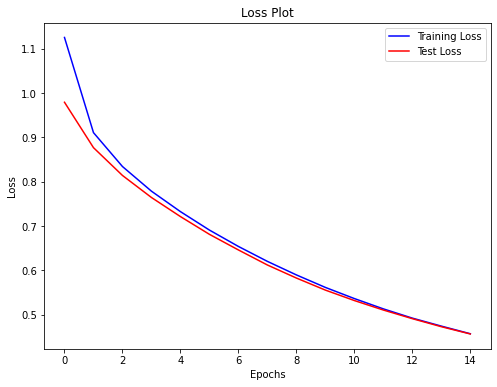

In [246]:
plt.figure(figsize = (8, 6))
plt.plot(loss_plot, 'b')
plt.plot(test_loss_plot, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(['Training Loss', 'Test Loss'], loc = 'upper right')
plt.show()

### Error plots:

We can clearly see from the above that:
* Both training and test loss are reducing monotonically
* The train loss is only marginally lower than the test loss and there is no overfitting
* Below, we evalute the model by:
  1. Viewing the picture, original caption and generated caption manually
  2. Computing the 4-gram BLEU score

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [265]:
attention_features_shape = 64
max_length = 39      #max_len_capt
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))


    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image, 2)[0], 0)         #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)    # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    print(f'Image Tensor Test shape: {img_tensor_val.shape}')

    features = encoder(img_tensor_val)                           # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    print(dec_input.shape)

    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)    # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()        #extract the predicted id(embedded value) which carries the max value
#        print(predicted_id)
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [266]:
from PIL import Image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(20, 18))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (12, 12))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

40021
Image Tensor Test shape: (1, 64, 2048)
(1, 1)
Real Caption: <start> three children climb on a livestock fence <end>
Prediction Caption: two young child in an orange scarves on a fence


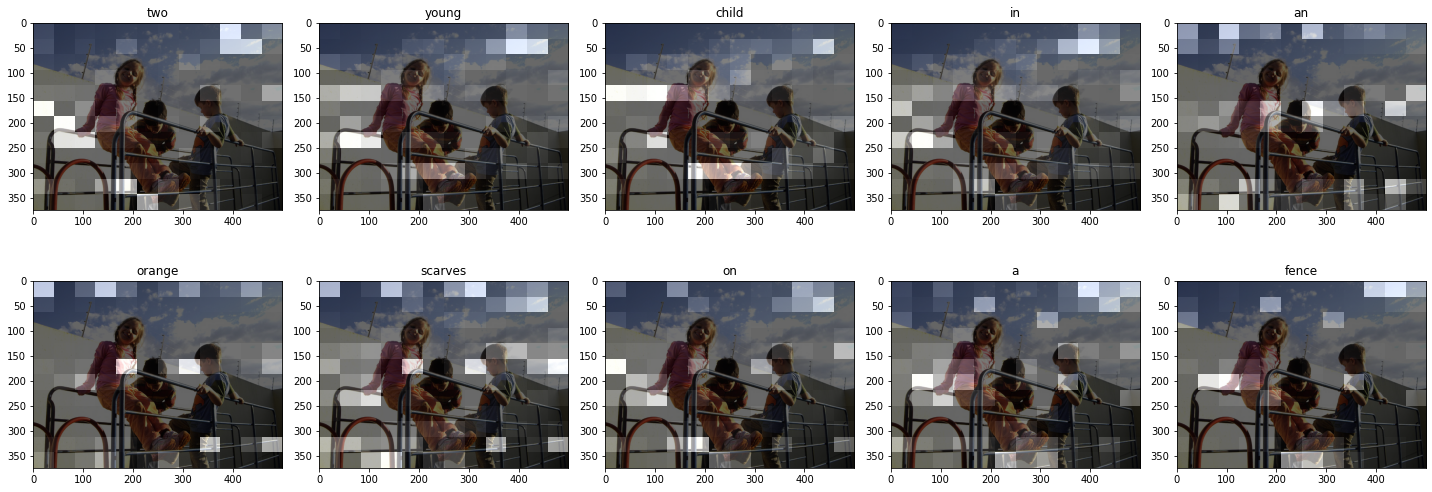

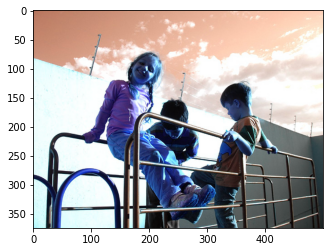

In [309]:
import cv2
rid = np.random.randint(lset, num_entities)
print(rid)
image = df.Path.iloc[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in list(df.cvec.iloc[rid]) if i not in [0]])
result, attention_plot, predictons = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result[0:-1]))
reference = real_caption
candidate = ' '.join(result[0:-1])
pred_caption = candidate
plot_attention(image, result[0:-1], attention_plot)
img = cv2.imread(image)
plt.imshow(img)
plt.show()

### Beam Search(optional)

In [310]:
# def beam_evaluate(image, beam_index = #your value for beam index):

#     #write your code to evaluate the result using beam search
                  
#     return final_caption



In [311]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [312]:
from nltk.translate.bleu_score import sentence_bleu

In [313]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

### BLEU score evaluation
* Here, the same prediction as above is used for calculating the BLEU score
* Instead of evaluating an image again, the same image is used for BLEU calculation

BELU score: 75.1620038893344
Real Caption: <start> three children climb on a livestock fence <end>
Prediction Caption: two young child in an orange scarves on a fence


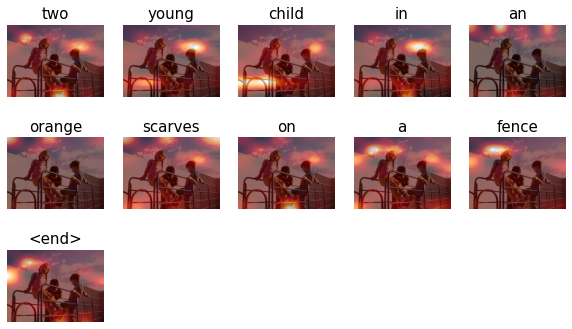

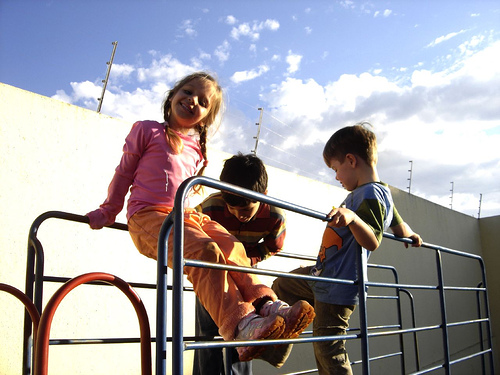

In [314]:
test_image = df.Path.iloc[rid]
real_caption=filt_text(real_caption)      

real_appn = []
real_appn.append(real_caption.split())

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))   #set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', reference)
print ('Prediction Caption:', candidate)

plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

## Conclusion
* We can see that for the above image, BLEU score is a decent 77%.
* However, this has not been the case for all images. The BLEU score has been 0 for some images as well
* But it has been found that the BLEU score is generally above 50% for most images.
* Further, in many images, the captions, though not absolutely perfect (sometimes they are too long), they give a decent indication of what is going on in the picture.

**Some of the improvements that could be made are:**
1. Combine all the 5 captions for an image and preprocess only 8091 images, instead of 40455 images. This will help improve scalability
2. The embed_dim has been increased here, to 512 (it has been changed from 256 to 512). This could be checked with 256 again. However, it was seen that slightly smaller errors were observed with this being 512
3. More images and tokens for training would improve caption correctness

In [255]:
# captions=beam_evaluate(test_image)
# print(captions)